# Trellis plots that work after Michele's "phase 3" changes 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.scalerel.allenhayes2017 import AllenHayesInterfaceBilinear
from openquake.hazardlib.const import TRT, StdDev
from openquake.hazardlib.contexts import ContextMaker
from openquake.hazardlib.imt import PGA, SA
from matplotlib import pyplot

# import these functions from the utils.py file
from utils import GmcLt, get_rupture, get_sites_from_rupture

### Get GMPEs from logic tree (not used here)

In [4]:
fname = './data/gmmLTs/gmmLTrisk_site_model.xml'
fname = './data/gmmLTs/gmmLTrisk_corrected.xml'
fname = './data/gmmLTs/gmmLT_trash.xml'
fname = '/Users/mpagani/Repos/mosaic/SAM/in/gmmLT.xml'

gmclt = GmcLt.from_file(fname)
imt = SA(0.3)
stds = [StdDev.TOTAL]

trts = [TRT.ACTIVE_SHALLOW_CRUST, 'Active Shallow Crust CCA']
# trts = ['Subduction Interface', 'Subduction Interface CCA']

### Plot GMPEs from a list

/home/hadi/miniconda/lib/python3.8/site-packages/openquake.engine-3.14.0-py3.8.egg/openquake/hazardlib/gsim/base.py:305: ExperimentalWarning: KuehnEtAl2020SInter is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)


TypeError: '>' not supported between instances of 'float' and 'str'

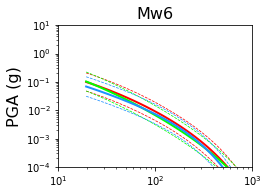

In [6]:
from openquake.hazardlib.gsim.abrahamson_2014 import AbrahamsonEtAl2014
from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014
from openquake.hazardlib.gsim.campbell_bozorgnia_2014 import CampbellBozorgnia2014
from openquake.hazardlib.gsim.chiou_youngs_2014 import ChiouYoungs2014

from openquake.hazardlib.gsim.abrahamson_2015 import AbrahamsonEtAl2015SInter, AbrahamsonEtAl2015SSlab
from openquake.hazardlib.gsim.abrahamson_gulerce_2020 import AbrahamsonGulerce2020SInter, AbrahamsonGulerce2020SSlab
from openquake.hazardlib.gsim.si_2020 import SiEtAl2020SInter, SiEtAl2020SSlab
from openquake.hazardlib.gsim.kuehn_2020 import KuehnEtAl2020SInter, KuehnEtAl2020SSlab
from openquake.hazardlib.gsim.parker_2020 import ParkerEtAl2020SInter, ParkerEtAl2020SSlab

from openquake.hazardlib.gsim.atkinson_boore_2003 import AtkinsonBoore2003SInter, AtkinsonBoore2003SSlab
from openquake.hazardlib.gsim.youngs_1997 import YoungsEtAl1997SInter, YoungsEtAl1997SSlab
from openquake.hazardlib.gsim.megawati_pan_2010 import MegawatiPan2010

from openquake.hazardlib.gsim.nga_east import NGAEastGMPE

######################
# Input Parameters
######################

gmpe_list=[AbrahamsonGulerce2020SInter(), KuehnEtAl2020SInter(), ParkerEtAl2020SInter(),
          NGAEastGMPE(gmpe_table='NGAEast_BOORE_A04_J15.hdf5')]

colors=['r', 'orange', 'gold', 'lime', 'dodgerblue', 'm', 'k', 'y']
colors=['r', 'lime', 'dodgerblue', 'k']

# Parameters that change by subplot 
mag_list = [6,7,8,9]
imt_list = [PGA(), SA(0.3), SA(1.0), SA(2.0)] ############# PGA NEEDS "()"

                                                   
######################
# Plot SA vs Distance
######################

fig = pyplot.figure(figsize=(16, 12))

for n, i in enumerate(imt_list): #iterate though imt_list, use this number for defining subplots
    
    for l, m in enumerate(mag_list):  #iterate though mag_list, use this number for defining subplots
    
        fig.add_subplot(len(imt_list), len(mag_list), l+1+n*len(mag_list)) #(#vert, #hor, #subplot)
        
        for gmpe, col in zip(gmpe_list, colors): 
            
            trt = gmpe.DEFINED_FOR_TECTONIC_REGION_TYPE
            # next part from utils.py, calls PlanarSurface.from_hypocenter()
            rup = get_rupture(0.0, 0.0, 20.0, WC1994(), mag=m, aratio=10.0, strike=0, dip=20, rake=79, trt=trt)
            #print('mag:', m, 'area:', rup.surface.get_area())
            props = {'vs30': 800.0, 'z1pt0': 30.0, 'z2pt5': 0.2, 'backarc': True, 'vs30measured': True}
            sites = get_sites_from_rupture(rup, from_point='TC', toward_azimuth=90, direction='positive', 
                                              hdist=1000, step=10.0, site_props=props)

            # Getting contexts the new way, see https://github.com/gem/oq-engine/pull/7064/files
            # also see https://github.com/gem/oq-engine/blob/master/openquake/hazardlib/contexts.py#L148
            # I think this is technically the old way, but with back-compatibility (i.e. contexts are converted to recarrays)
            param = dict(imtls={})
            cm = ContextMaker(trt, [gmpe], param)
            #rctx, sctx, dctx = cm.make_contexts(sites, rup)
            ctxs = cm.get_ctxs([rup], sites)
            ctxs = ctxs[0]
            ctxs.occurrence_rate = 0.0
            
            mean, std = gmpe.get_mean_and_stddevs(ctxs, ctxs, ctxs, i, [StdDev.TOTAL])
            distances = ctxs.rrup

            label=type(gmpe).__name__
            pyplot.plot(distances, np.exp(mean), color=col, linewidth=2, linestyle='-', label=label)

            #Plot Sigma 
            pyplot.plot(distances, np.exp(mean+std[0]), linewidth=0.75, color=col, linestyle='--')
            pyplot.plot(distances, np.exp(mean-std[0]), linewidth=0.75, color=col, linestyle='--')

            if n == 0: #top row only
                pyplot.title('Mw' + str(m), fontsize='16')
            if n == len(mag_list)-1: #bottom row only
                pyplot.xlabel('Rrup (km)', fontsize='14')
            if l == 0: # left row only
                pyplot.ylabel(str(i) + ' (g)', fontsize='16')
            
            pyplot.loglog()
            pyplot.xlim(10, 1000)
            pyplot.ylim(0.0001, 10)
        
        pyplot.grid(axis='both', which='both', alpha=0.5)
    
pyplot.legend(loc="center left", bbox_to_anchor=(1.1, 1.05), fontsize='16')
#pyplot.savefig('figure.png', bbox_inches='tight',dpi=200,pad_inches = 0.2)
pyplot.show()
pyplot.tight_layout()


In [5]:
%%bash
open .